In [954]:
# All the imports you will need in the whole lab
from skimage import io
from skimage.filters import median, gaussian
import skimage.exposure as exposure
from scipy.signal import convolve2d
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, skeletonize, thin
from skimage.color import rgb2gray, rgb2hsv, rgb2yuv, rgb2ycbcr
from skimage.measure import find_contours
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.feature import hog as hog_sk
import os
import numpy as np
from commonfunctions import *
import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage.util import img_as_float
from scipy.spatial.distance import squareform, pdist, cdist
from skimage.draw import polygon
from sklearn import svm
from joblib import dump, load

In [819]:
def skin_mask_rgb(img):
    red_channel = img[:,:,0]
    green_channel = img[:,:,1]
    blue_channel = img[:,:,2]
    rgb_max = np.maximum(np.maximum(red_channel, green_channel), blue_channel)
    rgb_min = np.minimum(np.minimum(red_channel, green_channel), blue_channel)
    rgb_rule_1 = np.logical_and.reduce([
        red_channel > 95, green_channel > 60, blue_channel > 60,
        rgb_max - rgb_min > 15, abs(red_channel - green_channel) < 80, abs(red_channel - blue_channel) < 80,red_channel > green_channel, red_channel > blue_channel
    ])
    
    rgb_rule_2 = np.logical_and.reduce([
        red_channel > 220 , green_channel > 210 , blue_channel > 170,
        abs(red_channel - green_channel) > 15, red_channel > blue_channel, green_channel > blue_channel
    ])
    return np.logical_or(rgb_rule_1, rgb_rule_2)

In [820]:
def adaptive_thresholding(img):
    hist = exposure.histogram(img, nbins=256)
    total_num_of_pixels = img.shape[0]*img.shape[1]
    initial_threshold = round(sum(hist[1]*hist[0])/total_num_of_pixels)
    grey_level_count = hist[1][-1]
    while True:
        list_of_lower_values = hist[1][hist[1] < initial_threshold]
        frequency_of_lower_values = hist[0][hist[1] < initial_threshold]
        lower_threshold = round(sum(list_of_lower_values*frequency_of_lower_values)/sum(frequency_of_lower_values))

        list_of_higher_values = hist[1][hist[1] >= initial_threshold]
        frequency_of_higher_values = hist[0][hist[1] >= initial_threshold]
        upper_threshold = round(sum(list_of_higher_values*frequency_of_higher_values)/sum(frequency_of_higher_values))
        new_threshold = round((lower_threshold + upper_threshold)/2)
        
        if new_threshold == initial_threshold:
            break
        else:
            initial_threshold = new_threshold
    return new_threshold

In [821]:
def get_hand_contours(hand_img):
    #get the center of the hand
    hand_img = hand_img.astype(np.uint8)
    contours = find_contours(hand_img, 0.8, fully_connected='high')
    contouring_threshold = 0
    # get contoring threshold by finding the average length of the longest 3 contours
    contouring_threshold = np.mean(sorted([len(c) for c in contours])[-3:])
    contours_saved = []
    for c in contours:
    #draw the contour if it is not too small
        if c.shape[0] > contouring_threshold: 
            #plt.plot(c[:, 1], c[:, 0], linewidth=2)
            contours_saved.append(c)
    return contours_saved


In [822]:
def normalize_img(img):
    #resize photo so that only the hand is visible
    # get the most left pixel that is not black
    most_left = np.where(img.sum(axis=0) != 0)[0][0]
    most_top = np.where(img.sum(axis=1) != 0)[0][0]
    most_right = np.where(img.sum(axis=0) != 0)[0][-1]
    most_bottom = np.where(img.sum(axis=1) != 0)[0][-1]
    resized_img = img[most_top:most_bottom, most_left:most_right]
    return resized_img

In [823]:
def trace_hand_contours(img, longest_contours):
    outline = np.zeros(img.shape)
    for c in longest_contours:
        #convert c to int
        c = c.astype(int)
        outline[c[:,0], c[:,1]] = 1
    return outline

In [824]:
def fill_hand(img, contours):
    #fill the hand with white
    result = img.astype(np.uint8)
    for c in contours:
        rr, cc = polygon(c[:,0], c[:,1])
        result[rr, cc] = 1
    return result

In [945]:
def is_bright(img):
    img = rgb2hsv(img)
    v = img[:,:,2]
    v = v*255
    v = gaussian(v, sigma=1)
    thresh = adaptive_thresholding(v)
    print(thresh)
    if thresh > 80:
        print("bright")
        return True
    else:
        print("dark")
        return False

In [826]:
def feature_extraction(img):
    #feature is a 25x25 matrix each cell is the output birghtness of a 5x5 pixel in the image
    b = np.zeros((42,42))
    #we get the brightness of each cell by taking the average of the brightness of the pixels in the cell
    for i in range(0,42):
        for j in range(0,42):
            b[i,j] = np.sum(img[i*3:(i+1)*3,j*3:(j+1)*3])
    # print(b)
    #show_images([b], ['feature'])
    return b

In [827]:
def compare_feature(b1, b2):
    #compare the feature of two images
    #if the two feature are black we consider them the same
    #if the two feature are white have the same brightness we consider them the same
    #if the two feature are white but have different brightness whithin a certain threshold we consider them the same
    print(np.max(b1), np.min(b1))
    print(np.max(b2), np.min(b2))
    matches = 0
    for i in range(0,42):
        for j in range(0,42):
            if (b1[i,j] == 0 and b2[i,j] == 0):
                matches = matches + 1
            # elif (b1[i,j] == b2[i,j]):
            #     matches = matches + 1
            elif (b1[i,j] > 0.2 and b2[i,j] > 0.2):
                matches = matches + 1
    print (matches)
    print (matches/(42*42))

In [843]:
def resize_img(img1):
    #resize photo to 200x200
    img_new = resize(img1, (256, 256), anti_aliasing=False)
    return img_new

In [829]:
def pre_processing (img):
    if(is_bright(img) == False):
        img = rgb2gray(img)
        img = img*255
        filterd = gaussian(img, sigma=1)
        best_threshold = adaptive_thresholding(filterd)
        thresholded = filterd > best_threshold
        result = thresholded
        result = normalize_img(thresholded)
        result = resize_img(result)
    else:
        mask = skin_mask_rgb(img)
        longest_contours = get_hand_contours(mask)
        result = trace_hand_contours(mask, longest_contours)
        result = fill_hand(result, longest_contours)
        result = normalize_img(result)
        result = resize_img(result)
    return result 

In [857]:
def compute_gradient(image):
    image = image.astype(np.float32)
    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)
    gx[:, 1:-1] = (image[:, 2:] - image[:, :-2]) / 2
    gy[1:-1, :] = (image[2:, :] - image[:-2, :]) / 2
    
    gx[:, 0] = image[:, 1] - image[:, 0]
    gy[0, :] = image[1, :] - image[0, :]
    
    gx[:, -1] = image[:, -1] - image[:, -2]
    gy[-1, :] = image[-1, :] - image[-2, :]
    return gx, gy

In [845]:
def hog_cell(orientations, magnitudes, n):
    bin_size = int(180 / n)
    hog = np.zeros(n)
    for i in range(orientations.shape[0]):
        for j in range(orientations.shape[1]):
            angle = orientations[i, j]
            magnitude = magnitudes[i, j]
            bin = int(angle / bin_size)
            if bin == n:
                bin = n - 1
            hog[bin] += magnitude
            
    return hog/(magnitudes.shape[0]*magnitudes.shape[1])

In [832]:
def normalize_vector(v):
    epsion = 1e-5
    return v / np.sqrt(np.sum(v ** 2) + epsion ** 2) 

In [833]:
def get_hog_featrue(img):
    gx, gy = compute_gradient(img)
    x, y = gx.shape
    cx , cy = 8, 8
    bx , by = 1, 1
    
    magnitude = np.sqrt(gx**2 + gy**2)
    angels = np.rad2deg(np.arctan2(gy, gx)) % 180
    
    n_cells_x = int(x / cx)
    n_cells_y = int(y / cy)
    n_blocks_x = n_cells_x - bx + 1
    n_blocks_y = n_cells_y - by + 1
    
    cells = np.zeros((n_cells_x, n_cells_y, 9))
    prev_x = 0
    for i in range(n_cells_x):
        prev_y = 0
        for j in range(n_cells_y):
            cells[i, j] = hog_cell(angels[prev_x:prev_x+cx, prev_y:prev_y+cy], magnitude[prev_x:prev_x+cx, prev_y:prev_y+cy], 9)
            prev_y += cy
        prev_x += cx
    
    cells_norm = np.zeros((n_blocks_x, n_blocks_y, 9))
    #normalize the cells
    
    for i in range(n_blocks_x):
        for j in range(n_blocks_y):
            cells_norm[i, j] = normalize_vector(cells[i:i+bx, j:j+by].ravel())
            
    return cells_norm.ravel()

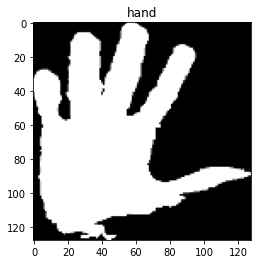

In [834]:
img = io.imread('images/hand3.jpg')
r = pre_processing(img)
show_images([r], ['hand'])
gr = rgb2gray(img)
gr = gr*255
hog_features = get_hog_featrue(gr)

In [835]:
def get_paper_hand_imgs():
    imgs = []
    labels = []
    #open folder with paper hands
    #get all images in folder and append to imgs
    path = 'C:/Users/Fastora/Downloads/HandGestureDetection/data/data/train/five/'
    
    for filename in os.listdir(path):
        img = io.imread(path+filename)
        imgs.append(img)
        labels.append("paper")
    return imgs, labels

def get_rock_hand_imgs():
    imgs = []
    labels = []
    #open folder with rock hands
    #get all images in folder and append to imgs
    path = 'C:/Users/Fastora/Downloads/HandGestureDetection/data/data/train/fist/'
    
    for filename in os.listdir(path):
        img = io.imread(path+filename)
        imgs.append(img)
        #extract features hog
        labels.append("rock")
    return imgs, labels

def get_peace_hand_imgs():
    imgs = []
    labels = []
    #open folder with scissors hands
    #get all images in folder and append to imgs
    path = 'C:/Users/Fastora/Downloads/HandGestureDetection/data/data/train/peace/'
    
    for filename in os.listdir(path):
        img = io.imread(path+filename)
        imgs.append(img)
        labels.append("peace")
    return imgs, labels

def get_okay_hand_imgs():
    imgs = []
    labels = []
    #open folder with thumbs up hands
    #get all images in folder and append to imgs
    path = 'C:/Users/Fastora/Downloads/HandGestureDetection/data/data/train/okay/'
    
    for filename in os.listdir(path):
        img = io.imread(path+filename)
        imgs.append(img)
        labels.append("okay")
    return imgs, labels

def get_up_hand_imgs():
    imgs = []
    labels = []
    #open folder with up hands
    #get all images in folder and append to imgs
    path = 'C:/Users/Fastora/Downloads/HandGestureDetection/data/data/train/straight/'
    
    for filename in os.listdir(path):
        img = io.imread(path+filename)
        imgs.append(img)
        labels.append("up")
    return imgs, labels

In [836]:
def extract_features(imgs_labels, feature_vector=True):
    features = []
    labels = []
    for img_label in imgs_labels:
        #get hog features of image and append to features and label to labels
        fd = get_hog_featrue(img_label[0])
        labels.append(img_label[1])
        features.append(fd)
    return features, labels

In [837]:
paper_imgs , paper_labels = get_paper_hand_imgs()#539
# take 80% of the images to train
#paper_imgs = paper_imgs[:int((.8)*len(paper_imgs))]
#paper_labels = paper_labels[:int((.8)*len(paper_labels))]

rock_imgs , rock_labels = get_rock_hand_imgs()
#rock_imgs = rock_imgs[:int((.8)*len(rock_imgs))]
#rock_labels = rock_labels[:int((.8)*len(rock_labels))]

peace_imgs , peace_labels = get_peace_hand_imgs()
#peace_imgs = peace_imgs[:int((.8)*len(peace_imgs))]
#peace_labels = peace_labels[:int((.8)*len(peace_labels))]

okay_imgs , okay_labels = get_okay_hand_imgs()
#okay_imgs = okay_imgs[:int((.8)*len(okay_imgs))]
#okay_labels = okay_labels[:int((.8)*len(okay_labels))]

up_imgs , up_labels = get_up_hand_imgs()
#up_imgs = up_imgs[:int((.8)*len(up_imgs))]
#up_labels = up_labels[:int((.8)*len(up_labels))]

In [ ]:
imgs_labels = []
for i in range(len(paper_imgs)):
    imgs_labels.append((paper_imgs[i], paper_labels[i]))
for i in range(len(rock_imgs)):
    imgs_labels.append((rock_imgs[i], rock_labels[i]))
for i in range(len(peace_imgs)):
    imgs_labels.append((peace_imgs[i], peace_labels[i]))
for i in range(len(okay_imgs)):
    imgs_labels.append((okay_imgs[i], okay_labels[i]))
for i in range(len(up_imgs)):
    imgs_labels.append((up_imgs[i], up_labels[i]))

In [839]:
features , labels = extract_features(imgs_labels)

In [840]:
clf = svm.SVC()
clf.fit(features, labels)

SVC()

120
bright


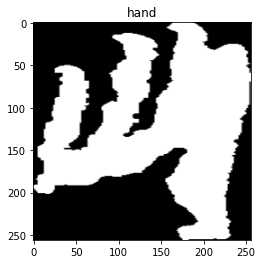

array(['paper'], dtype='<U5')

In [955]:
#dump(clf, 'model.joblib')
img = io.imread('images/hand1.jpg')
r = pre_processing(img)
show_images([r], ['hand'])
gr = rgb2gray(img)
gr = gr*255
hog_features = get_hog_featrue(r)
clf.predict([hog_features])